In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
# import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#import shao
import pickle
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
import sys

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.0 MB/s eta 0:00:00


In [3]:
import shap

In [4]:
plt.rcParams["mathtext.fontset"]
plt.rcParams.update({'font.size': 28, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [5]:
transaction_frequency_opcode = ['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
 'payment_out', 'investment_to_contract/tx_in', 'payment_from_contract/tx_out',
 '#addresses_paying_contract', '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2', 'sdev_v2', 'paid_rate',
 'paid_one', 'percentage_some_tx_in', 'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'owner_gets_eth_Wo_investing',
 'owner_gets_eth_investing', 'owner_no_eth', 'PUSH', 'INVALID', 'DUP', 'JUMPDEST', 'STOP', 'MSTORE', 'JUMPI', 'REVERT', 'CALLVALUE',
 'ISZERO', 'CODECOPY', 'RETURN', 'LOG', 'SHA3', 'MSTORE8', 'SWAP', 'POP', 'ADD', 'MLOAD', 'AND', 'SUB', 'CALLDATALOAD', 'EXP',
 'MUL', 'SLOAD', 'EQ', 'JUMP', 'DIV', 'CALLER', 'CALLDATACOPY', 'SSTORE', 'NOT', 'CALL', 'LT', 'GT', 'OR', 'ADDRESS2', 'TIMESTAMP',
 'GASLIMIT', 'GAS', 'ORIGIN', 'BALANCE3', 'CALLDATASIZE', 'SAR', 'MSIZE', 'CODESIZE', 'COINBASE', 'CREATE2', 'EXTCODESIZE', 'CALLCODE', 'SHL',
 'BLOCKHASH', 'RETURNDATASIZE', 'SHR', 'GETPC', 'DELEGATECALL', 'MOD', 'ADDMOD', 'NUMBER', 'XOR', 'SLT', 'EXTCODECOPY', 'MULMOD', 'CREATE', 'SELFDESTRUCT',
 'STATICCALL', 'RETURNDATACOPY', 'SGT', 'DIFFICULTY', 'SMOD', 'BYTE', 'SIGNEXTEND', 'CHAINID', 'SELFBALANCE', 'GASPRICE', 'EXTCODEHASH', 'SDIV', 'target']

In [6]:
best_features_set = ['balance',
 'lifetime',
 'tx_in',
 'investment_to_contract/tx_in',
 'sdev_v2',
 'paid_rate',
 'PUSH',
 'INVALID',
 'DUP',
 'JUMPDEST',
 'STOP',
 'JUMPI',
 'REVERT',
 'CALLVALUE',
 'ISZERO',
 'CODECOPY',
 'RETURN',
 'LOG',
 'SHA3',
 'SWAP',
 'POP',
 'ADD',
 'MLOAD',
 'AND',
 'SUB',
 'CALLDATALOAD',
 'EXP',
 'MUL',
 'SLOAD',
 'JUMP',
 'DIV',
 'CALLER',
 'SSTORE',
 'NOT',
 'CALL',
 'LT',
 'GT',
 'OR',
 'TIMESTAMP',
 'GAS',
 'BALANCE3',
 'CALLDATASIZE',
 'RETURNDATASIZE']



In [7]:
#dataset_path = ("\\Users\\lucap\\OneDrive\\Desktop\\Smart Ponzi\\bytecode_opcode_8k.csv")
dataset_path = ("/content/bytecode_opcode_8k.csv")
db = pd.read_csv(dataset_path, header = 0, delimiter = ';')
db = db.fillna(0)

In [8]:
df_transaction_weighted_opcode = db[transaction_frequency_opcode].copy()
y = df_transaction_weighted_opcode.loc[:, ['target']].values
y = pd.DataFrame(y,columns=['target'])

dataset_account = db.iloc[:, 0:24]
dataset_opcode = db.iloc[:, 24:101]

dataset_opcode['all_opcode'] = dataset_opcode[list(dataset_opcode.columns)].sum(axis=1) #generate all_opcode
dataset_opcode = dataset_opcode[:].div(dataset_opcode['all_opcode'], axis=0)
dataset_opcode = dataset_opcode.drop(['all_opcode'], axis = 1)

df_transaction_weighted_opcode = pd.concat([dataset_account, dataset_opcode, y], axis=1)
df_transaction_weighted_opcode = df_transaction_weighted_opcode.fillna(0)

In [9]:
col_name = transaction_frequency_opcode[1:-1]

In [10]:
X = df_transaction_weighted_opcode.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
y = df_transaction_weighted_opcode.loc[:, ['target']].values

X = pd.DataFrame(X)
X.columns = col_name

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42, stratify=y)

In [12]:
best_params =[

        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1],
            'classifier__n_estimators' : [140],
            'classifier__max_depth' : [15],
            'classifier__colsample_bytree' : [0.5],
            'classifier__reg_alpha' : [0.1],
            'classifier__reg_lambda' : [1],
        }
]

In [13]:
data = {}
pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(pipeline, best_params, cv=10,
                               scoring='roc_auc',
                               return_train_score=True,n_jobs=4,verbose=2)
grid_search.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid=[{'classifier': [LGBMClassifier(colsample_bytree=0.5,
                                                        max_depth=15,
                                                        n_estimators=140,
                                                        n_jobs=4,
                                                        random_state=42,
                                                        reg_alpha=0.1,
                                                        reg_lambda=1)],
                          'classifier__colsample_bytree': [0.5],
                          'classifier__learning_rate': [0.1],
                          'classifier__max_depth': [15],
                          'classifier__n_estimators': [140],
                          'classifier__reg_alpha': [0.1],
                          'classifier__reg_lambda': [1]}],
             return_train_score=True, scoring='roc_auc', verbose=2)

In [14]:
print(grid_search.best_params_)
print('Test accuracy: %.3f' % grid_search.score(X_test, y_test))

{'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=140, n_jobs=4,
               random_state=42, reg_alpha=0.1, reg_lambda=1), 'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 15, 'classifier__n_estimators': 140, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1}
Test accuracy: 0.965


In [15]:
data = {}
y_pred_train = grid_search.best_estimator_.predict(X_train)
data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_training'] = [f1_score(y_train, y_pred_train)]
# Confusion matrix
y_pred = grid_search.best_estimator_.predict(X_test)
data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_test'] = [f1_score(y_test, y_pred)]

In [16]:
data

{'best_precision_training': [1.0],
 'best_recall_training': [0.9911838790931989],
 'best_accuracy_training': [0.9989655681986109],
 'best_f1_training': [0.995572422517394],
 'best_precision_test': [0.9067796610169492],
 'best_recall_test': [0.7642857142857142],
 'best_accuracy_test': [0.9631799163179916],
 'best_f1_test': [0.8294573643410853]}

In [17]:
model = grid_search.best_estimator_

In [18]:
df_X_train_full = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test,columns=df_transaction_weighted_opcode.columns[1:-1])

df_X_train_full = df_X_train_full[best_features_set].copy()
df_X_test_full = df_X_test_full[best_features_set].copy()

model.fit(df_X_train_full,y_train.ravel())
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba_best)
auc_score = roc_auc_score(y_test,y_pred_proba_best)


y_pred_best = model.predict(df_X_test_full)
best_precision_test= precision_score(y_test, y_pred_best) # TP / (FP + TP)
best_recall_test = recall_score(y_test, y_pred_best)	     # TP / (FN + TP)
best_accuracy_test = accuracy_score(y_test, y_pred_best)	 # (TP + TN)/ (TP + FN + TN + FP)
best_f1_test = f1_score(y_test, y_pred_best)

print('AUC: {:.3f}'.format(auc_score))
print('Precision: {:.3f}'.format(best_precision_test))
print('Recall: {:.3f}'.format(best_recall_test))
print('Accuracy: {:.3f}'.format(best_accuracy_test))
print('F1: {:.3f}'.format(best_f1_test))

AUC: 0.964
Precision: 0.926
Recall: 0.800
Accuracy: 0.969
F1: 0.858


In [19]:
np.set_printoptions(threshold=sys.maxsize)

In [20]:
def plot_confusion_matrix(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, fmt='d',annot_kws={"fontsize":38})
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=38)
    plt.yticks(fontsize=38)
    plt.savefig('cm_{}.png'.format(name))
    plt.show()

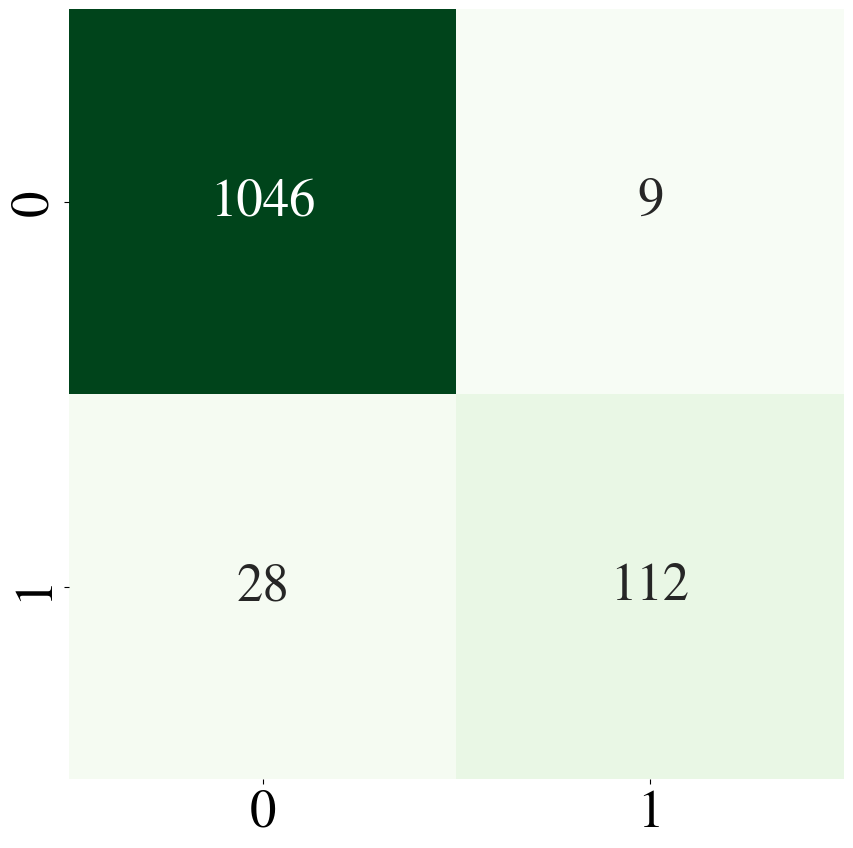

In [21]:
plot_confusion_matrix(y_test,y_pred_best,"Best features set")

In [22]:
cls = grid_search.best_estimator_

In [23]:
explainer_tree = shap.TreeExplainer(cls.named_steps['classifier'])
shap_values_tree = explainer_tree.shap_values(df_X_test_full)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [24]:
def get_shaps(classifier, dataset):
    print(dataset.shape)
    explainer = shap.Explainer(classifier, dataset)
    shap_values = explainer(dataset,check_additivity=False)

    explainer_tree = shap.TreeExplainer(classifier)
    shap_values_tree = explainer_tree.shap_values(dataset)
    return shap_values,shap_values_tree

In [25]:
def plot_beeswarn(df,shap_values,filename,class_index=1):
    shap.summary_plot(shap_values[class_index], df,show=False,max_display=10,color='red',color_bar=True,class_names=True)
    fig = plt.gcf() # gcf means "get current figure"
    ax = plt.gca() #gca means "get current axes"

    fig.axes[1].yaxis.get_label().set_fontsize(24)
    # fig.axes[1].set_fontsize(24)
    plt.xlabel('SHAP value',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.tight_layout()
    plt.savefig('{}.png'.format(filename))

In [26]:
explainer = shap.Explainer(cls.named_steps['classifier'], df_X_test_full)
shap_values = explainer(df_X_test_full,check_additivity=False)

 99%|===================| 1181/1195 [00:17<00:00]       

In [27]:
shap_values, shap_values_tree = get_shaps(cls.named_steps['classifier'], df_X_test_full)

(1195, 43)


 99%|===================| 1185/1195 [00:12<00:00]       LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


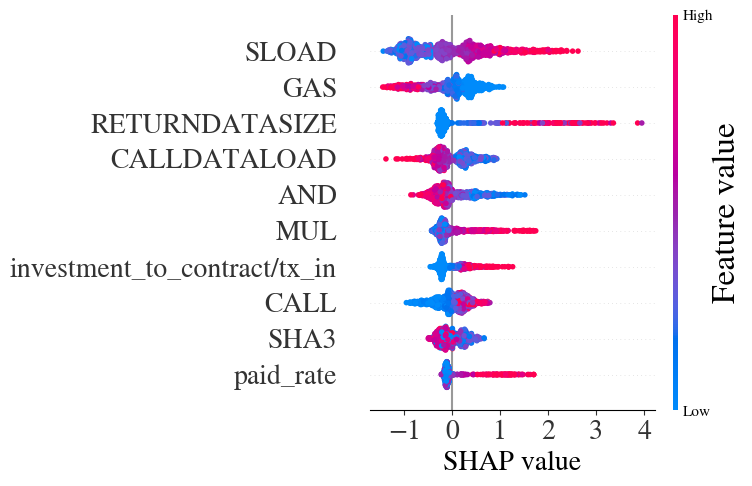

In [28]:
plot_beeswarn(df_X_test_full,shap_values_tree,'total',1)

In [29]:
from sklearn.inspection import PartialDependenceDisplay

In [30]:
top_ten = [
 'SLOAD',
 'GAS',
 'RETURNDATASIZE',
 'CALLDATALOAD',
 'AND',
 'MUL',
 'investment_to_contract/tx_in',
 'CALL',
 'SHA3',
 'paid_rate'
]

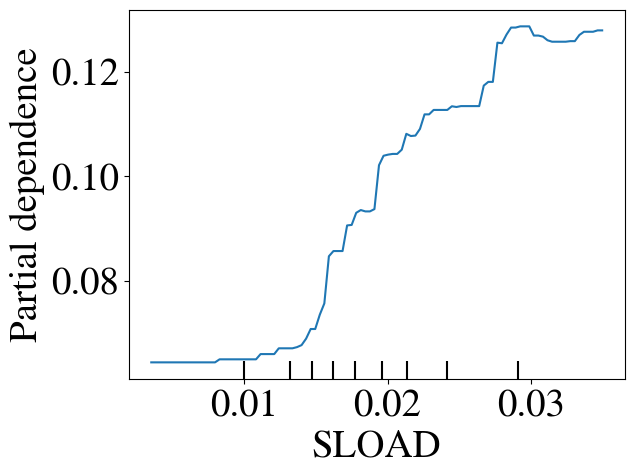

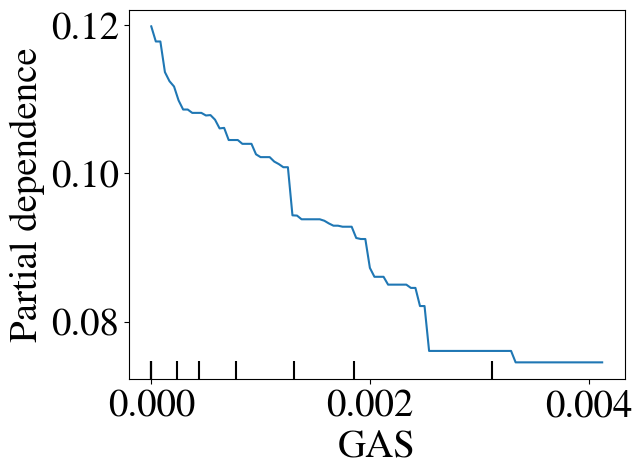

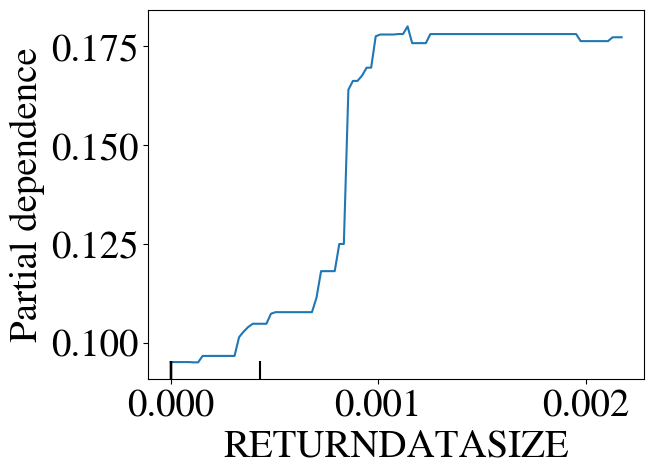

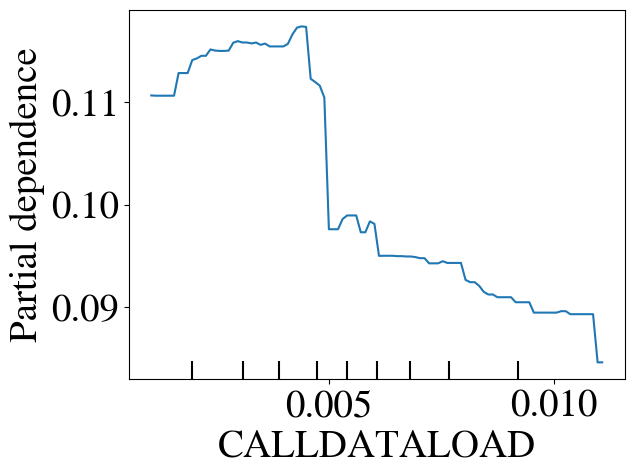

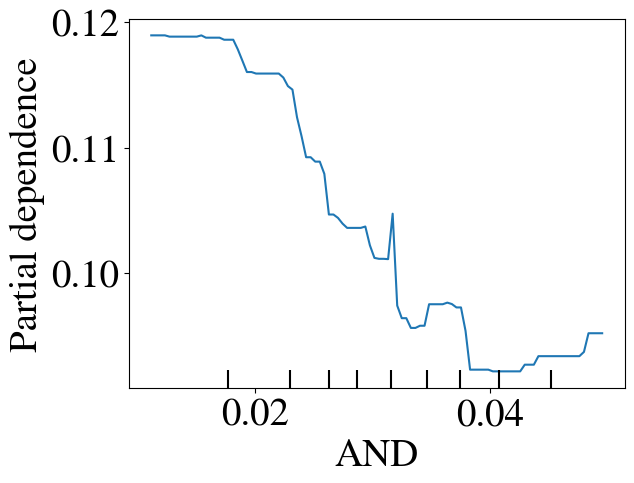

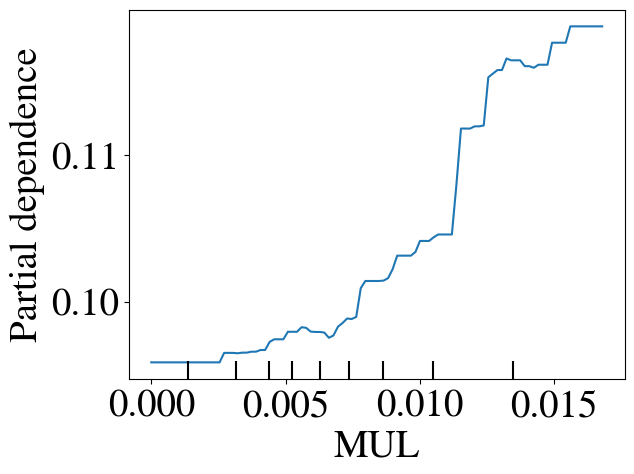

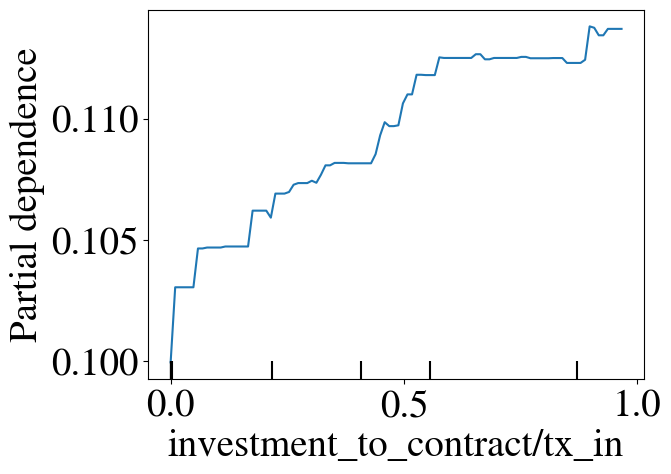

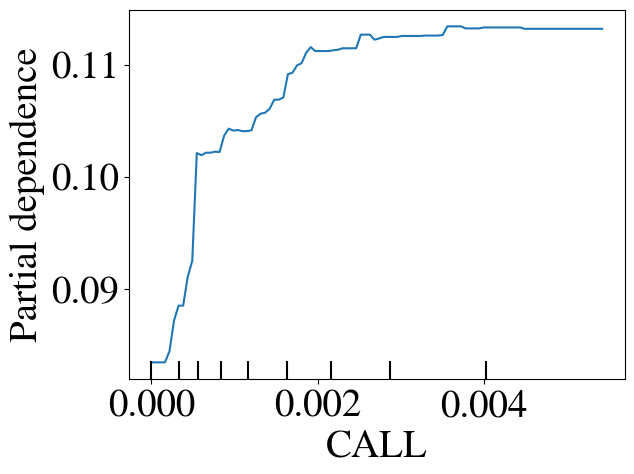

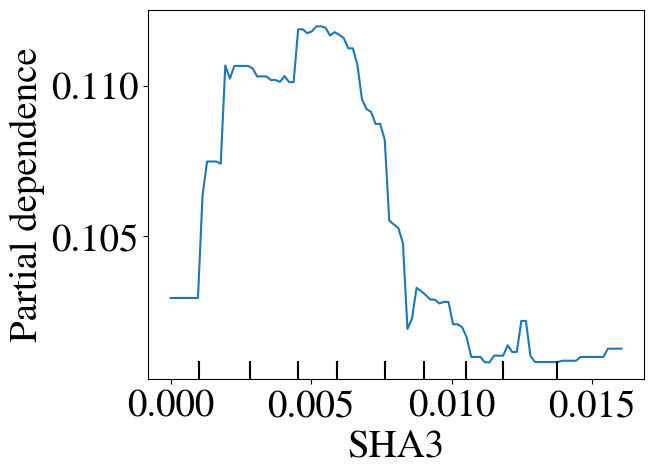

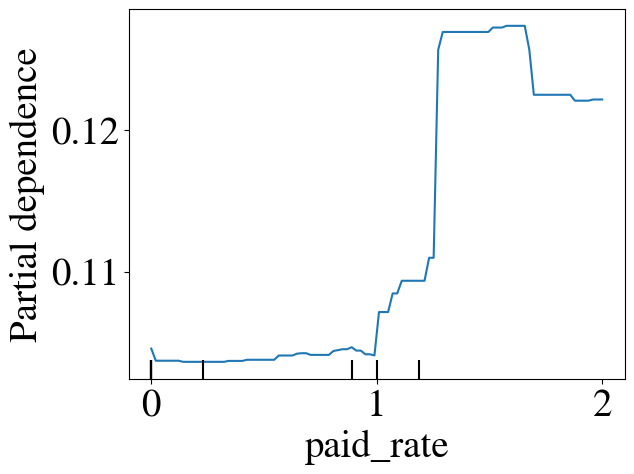

In [31]:
for x in top_ten:
  PartialDependenceDisplay.from_estimator(
    cls, df_X_test_full, [x])

In [32]:
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

In [33]:
model.predict_proba

<bound method Pipeline.predict_proba of Pipeline(steps=[('classifier',
                 LGBMClassifier(colsample_bytree=0.5, max_depth=15,
                                n_estimators=140, n_jobs=4, random_state=42,
                                reg_alpha=0.1, reg_lambda=1))])>

In [34]:
y_pred_proba_best

array([3.80848292e-02, 9.98629154e-01, 4.36141602e-04, 5.81267739e-03,
       4.74696411e-03, 1.35948081e-03, 4.80550916e-03, 2.00011071e-02,
       9.90331203e-01, 5.36534291e-03, 4.95298271e-05, 8.05977135e-04,
       2.69372625e-04, 3.91781006e-03, 1.57775941e-03, 8.23058777e-04,
       1.67696329e-03, 1.17288712e-03, 2.41372591e-04, 2.21824938e-04,
       1.24348093e-03, 1.05487663e-02, 4.08109044e-03, 9.44029952e-02,
       4.53310080e-04, 9.97379297e-01, 1.22195320e-02, 2.09300137e-03,
       8.70529743e-05, 2.63200523e-02, 1.94920795e-02, 6.90306717e-04,
       2.44372708e-04, 5.91325793e-04, 2.05217852e-03, 2.31463880e-03,
       3.45801290e-04, 4.80333162e-04, 9.95271997e-01, 5.09920388e-03,
       9.93105121e-01, 2.84889268e-02, 3.34506292e-03, 1.46858000e-03,
       2.71836198e-04, 7.87544429e-05, 2.61034831e-03, 2.10663009e-03,
       1.06533261e-03, 2.53550636e-04, 7.11848415e-03, 1.57286334e-03,
       5.91629833e-03, 2.64311556e-03, 8.87752515e-01, 2.47808987e-04,
      

False Negative and False Positive

In [35]:
df_check = df_X_test_full.copy()
df_check['prediction'] = y_pred
df_check['label'] = y_test
df_check['probability'] = y_pred_proba_best
df_check['correct'] = df_check.apply(lambda x: 1 if x.prediction == x.label else 0,axis=1)

In [36]:
df_check

balance  lifetime   tx_in  investment_to_contract/tx_in    sdev_v2  \
5386  0.000000       0.0     1.0                        0.0000   0.000000   
7297  0.106035     499.0   156.0                        0.3910   0.141623   
6502  0.100000    1785.0     8.0                        0.6250   2.066117   
7771  0.000000     603.0   749.0                        0.5073  30.533024   
2636  0.000000      86.0    30.0                        0.0333   0.010000   
...        ...       ...     ...                           ...        ...   
5581  0.000000       1.0    52.0                        0.9808   2.374534   
5772  0.000000       2.0    18.0                        0.8889   0.122391   
2325  0.000000       9.0  9880.0                        0.0000   0.000000   
2033  0.000000      11.0    19.0                        0.0000   0.000000   
3172  0.002123       1.0    17.0                        0.9412   0.010558   

      paid_rate      PUSH   INVALID       DUP  JUMPDEST  ...        OR  \
5386     0.0000  0.280497  0.005439  0.116550  0.036519  ...  0.007770   
7297     1.0820  0.265169  0.011236  0.143820  0.069213  ...  0.000000   
6502     1.0000  0.238737  0.018526  0.117053  0.066947  ...  0.004632   
7771     1.0000  0.211890  0.003818  0.185438  0.046359  ...  0.003000   
2636     1.0000  0.247638  0.011811  0.152756  0.053543  ...  0.001575   
...         ...       ...       ...       ...       ...  ...       ...   
5581     1.5294  0.267898  0.000469  0.170174  0.028323  ...  0.003521   
5772     0.5625  0.254409  0.012787  0.135362  0.063492  ...  0.004409   
2325     0.0000  0.244816  0.012368  0.143689  0.068025  ...  0.002546   
2033     0.0000  0.205209  0.013471  0.176920  0.062416  ...  0.003143   
3172     1.1875  0.255838  0.005228  0.155106  0.054374  ...  0.002091   

      TIMESTAMP       GAS  BALANCE3  CALLDATASIZE  RETURNDATASIZE  prediction  \
5386   0.000000  0.000000  0.001554      0.000777        0.000000         0.0   
7297   0.000000  0.000000  0.000000      0.000449        0.000000         1.0   
6502   0.001684  0.003368  0.000421      0.000421        0.000000         0.0   
7771   0.000000  0.000545  0.000000      0.003545        0.002182         0.0   
2636   0.000000  0.000394  0.000000      0.000394        0.000000         0.0   
...         ...       ...       ...           ...             ...         ...   
5581   0.001721  0.000000  0.000000      0.002034        0.000000         1.0   
5772   0.001323  0.000441  0.002205      0.000441        0.000000         0.0   
2325   0.000728  0.000728  0.000000      0.001091        0.000000         0.0   
2033   0.000449  0.000449  0.000000      0.000449        0.000000         0.0   
3172   0.000697  0.001046  0.000697      0.000349        0.000000         1.0   

      label  probability  correct  
5386    0.0     0.038085        1  
7297    1.0     0.998629        1  
6502    0.0     0.000436        1  
7771    0.0     0.005813        1  
2636    0.0     0.004747        1  
...     ...          ...      ...  
5581    1.0     0.997899        1  
5772    0.0     0.007589        1  
2325    0.0     0.000091        1  
2033    0.0     0.000782        1  
3172    1.0     0.943125        1  

[1195 rows x 47 columns]

In [37]:
pd.set_option('display.max_rows', None)

prediction	label	probability

In [38]:
df_check.sort_values(by=['probability'])

balance  lifetime    tx_in  investment_to_contract/tx_in  \
1963       0.000000     274.0   9961.0                        0.0000   
503        0.000000      45.0     11.0                        0.0000   
2487       0.000000    1479.0   7745.0                        0.0000   
6660       0.000000     143.0   7208.0                        0.0000   
606        0.000000     299.0     33.0                        0.0000   
1694       0.000000      53.0  10000.0                        0.0000   
6428       0.000000    1554.0    385.0                        0.0000   
280        0.000000     138.0     39.0                        0.0000   
3805       0.000000     145.0     12.0                        0.0000   
970        0.000000       0.0      2.0                        0.0000   
7826       0.000000       0.0      1.0                        0.0000   
2470       0.000000       3.0     26.0                        0.0000   
1165       0.000000       2.0      2.0                        0.0000   
2001       0.000000      12.0      5.0                        0.0000   
4659       0.000000     150.0   9998.0                        0.0000   
1722       0.000000    2008.0   6739.0                        0.0000   
4001      18.516095     490.0   9763.0                        0.0028   
4744       0.247000      55.0     33.0                        0.6970   
116        0.000000      11.0  10000.0                        0.0000   
903        0.000000     107.0   9998.0                        0.0000   
1713       0.000000      22.0   9904.0                        0.0000   
7041       0.000000     318.0    107.0                        0.0000   
3765       0.000000      45.0      7.0                        0.0000   
5306       0.000000       0.0      1.0                        0.0000   
337        0.000000      15.0   7117.0                        0.0000   
3005       0.000000     230.0     50.0                        0.0000   
5711       0.000000     395.0     13.0                        0.0000   
586        0.000000       6.0     31.0                        0.0000   
7560       0.000000     523.0   9876.0                        0.0000   
7117       0.000000     174.0   9178.0                        0.0000   
7708       2.889790     286.0   9711.0                        0.0004   
2944       0.000000      49.0     11.0                        0.0000   
2088       0.000000      24.0   4166.0                        0.0000   
5827       0.000000       0.0      2.0                        0.0000   
4898       0.000000       0.0      1.0                        0.0000   
7145       0.030000     278.0   9770.0                        0.0001   
3022       0.000000    1339.0   9837.0                        0.0000   
1708       0.000000       0.0      1.0                        0.0000   
3614       0.000000       0.0      1.0                        0.0000   
225        0.000000     678.0      8.0                        0.0000   
2325       0.000000       9.0   9880.0                        0.0000   
3206       0.000000     144.0      4.0                        0.0000   
4174       0.000000       0.0      1.0                        0.0000   
2952       0.000000       0.0      1.0                        0.0000   
2071       0.260000     230.0   8935.0                        0.0008   
5524       0.000194    2031.0   7521.0                        0.0001   
3065       0.000000       0.0      1.0                        0.0000   
1845       0.000000     618.0   5753.0                        0.0000   
3242       0.000000    1902.0     47.0                        0.0000   
4405       0.000000      94.0     15.0                        0.0000   
506        0.000000    1989.0     11.0                        0.0000   
7643       0.000000       0.0      1.0                        0.0000   
7611       0.000000      11.0      4.0                        0.0000   
3881       0.000000       1.0      3.0                        0.0000   
2186       0.000000       0.0      2.0              

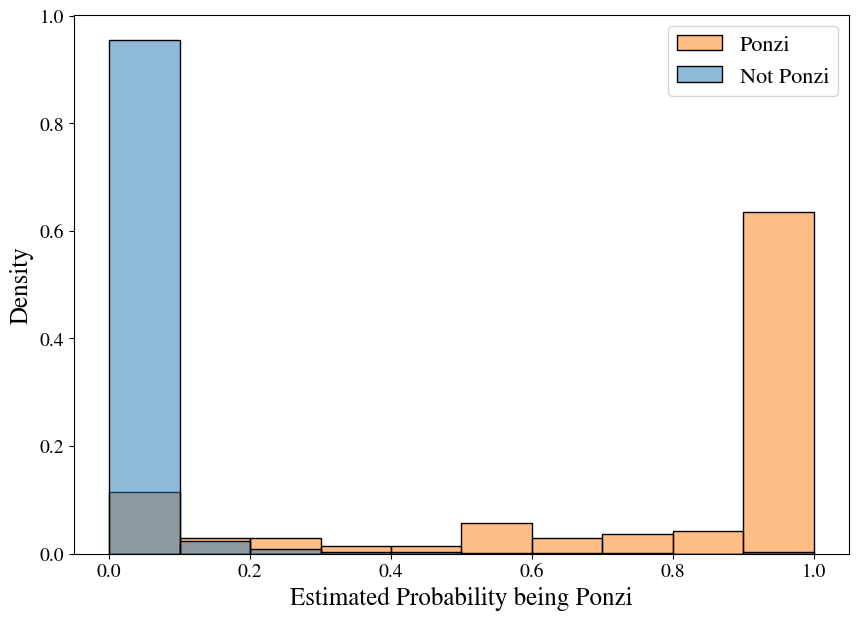

In [39]:
fig=plt.figure(figsize=(10,7))
sns.histplot(data=df_check,x='probability',hue='label',bins=np.arange(0,1.1,0.1),stat='probability',common_norm=False)
plt.xlabel('Estimated Probability being Ponzi',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='best',labels=['Ponzi','Not Ponzi'],fontsize=16)
plt.savefig('distribution_probability.png')

In [40]:
df_check['FP'] = df_check.apply(lambda x: 1 if x['prediction'] == 1 and x['correct'] ==0 else 0, axis=1 )
df_check['FN'] = df_check.apply(lambda x: 1 if x['prediction'] == 0 and x['correct'] ==0 else 0, axis=1 )

In [41]:
df_check

balance  lifetime    tx_in  investment_to_contract/tx_in  \
5386       0.000000       0.0      1.0                        0.0000   
7297       0.106035     499.0    156.0                        0.3910   
6502       0.100000    1785.0      8.0                        0.6250   
7771       0.000000     603.0    749.0                        0.5073   
2636       0.000000      86.0     30.0                        0.0333   
3497       0.000000    1179.0    296.0                        0.9054   
4093       0.000000     334.0   4758.0                        0.2379   
4499       0.000000       0.0      3.0                        0.0000   
6529       0.000000      32.0    214.0                        0.0000   
4474       0.000000      17.0     11.0                        0.1818   
606        0.000000     299.0     33.0                        0.0000   
7845      -0.047544      14.0   8987.0                        0.0657   
5200       0.000000       0.0      1.0                        0.0000   
2608       0.000000     287.0    144.0                        0.6042   
5612       0.020000      41.0     11.0                        0.5455   
7265       0.000000       0.0      2.0                        0.0000   
3466       0.000000    1371.0    111.0                        0.0901   
5378       0.000000      73.0   9116.0                        0.0000   
7927       0.000000     970.0   2251.0                        0.0000   
1705       0.025000    1734.0   2016.0                        0.0005   
6618       0.000000    1205.0      6.0                        0.1667   
4559       0.000000     260.0   3759.0                        0.9997   
1074       0.000000      92.0    540.0                        0.2981   
1322       0.000000       0.0      1.0                        0.0000   
2718       0.000000       4.0      4.0                        0.2500   
7914       0.000000       0.0      7.0                        0.5714   
705        0.000000       0.0      2.0                        0.0000   
5911       0.000000     118.0   7497.0                        0.1947   
7145       0.030000     278.0   9770.0                        0.0001   
6779       0.095205    1311.0     11.0                        0.1818   
6743      20.000000       3.0    204.0                        0.9608   
1741       0.000000     674.0      5.0                        0.0000   
5613       0.000000       0.0      3.0                        0.0000   
5896       0.000000       0.0      1.0                        0.0000   
4085       0.000000       0.0      1.0                        0.0000   
5277       0.000000      87.0    166.0                        0.0000   
1293       0.000000       4.0     17.0                        0.4118   
4486       0.000000       0.0      8.0                        0.0000   
3316       0.000000       0.0      3.0                        0.3333   
335        0.000000      24.0      9.0                        0.0000   
7001       3.853928    2422.0    291.0                        0.9141   
7765       0.000000       1.0     14.0                        0.0000   
1977       0.000000       0.0      2.0                        0.0000   
4903       0.000000       0.0      1.0                        0.0000   
7373       0.000000    1601.0   7058.0                        0.0275   
586        0.000000       6.0     31.0                        0.0000   
6304       0.015784    1138.0   1850.0                        0.9978   
2781       0.000000       0.0      4.0                        0.5000   
2434       0.000000       0.0      5.0                        0.0000   
6060       0.000000       0.0     16.0                        0.0000   
3482       0.991770    1324.0    407.0                        0.7862   
3556       0.000000       0.0      1.0                        0.0000   
1748       0.000000      37.0     25.0                        0.1600   
1848       0.000000     119.0   9437.0                        0.0660   
4032       0.000000       0.0      1.0              

In [42]:
df_fp = df_check[df_check['FP']==1].copy()
df_fn = df_check[df_check['FN']==1].copy()

In [43]:
df_fp

balance  lifetime  tx_in  investment_to_contract/tx_in    sdev_v2  \
2237  0.00000       0.0    4.0                        0.2500   0.100000   
5050  0.00100       0.0    2.0                        0.5000   0.000000   
1870  0.61460    2163.0  813.0                        0.2608  63.312962   
5794  0.00000       0.0    4.0                        0.5000   0.002298   
2582  0.00000       0.0    2.0                        0.0000   0.000000   
5611  0.00500      66.0   24.0                        0.9583   0.000000   
3054  0.00000       0.0    4.0                        0.5000   0.000000   
232   0.00000     398.0   12.0                        0.5000   0.249420   
3289  0.05800     256.0   97.0                        0.6907   0.139048   
7204  0.00000       0.0    2.0                        0.0000   0.000000   
568   0.04344     411.0   10.0                        0.6000   0.015860   

      paid_rate      PUSH   INVALID       DUP  JUMPDEST  ...       GAS  \
2237     1.0000  0.238411  0.000000  0.145695  0.069536  ...  0.000000   
5050     0.0000  0.239037  0.014177  0.168810  0.067260  ...  0.000000   
1870     1.2123  0.224524  0.000000  0.172452  0.030795  ...  0.000000   
5794     1.0000  0.252166  0.013432  0.131282  0.060659  ...  0.000433   
2582     0.0000  0.280449  0.002671  0.126603  0.036859  ...  0.000000   
5611     1.1739  0.213986  0.006768  0.192394  0.046084  ...  0.000000   
3054     0.5000  0.255618  0.009363  0.156367  0.062266  ...  0.000000   
232      4.6667  0.252729  0.005458  0.154072  0.059194  ...  0.000000   
3289     0.3881  0.225166  0.007174  0.188558  0.035872  ...  0.000000   
7204     0.0000  0.231074  0.002969  0.150915  0.040079  ...  0.000495   
568      0.5000  0.252900  0.000000  0.135151  0.071926  ...  0.000000   

      BALANCE3  CALLDATASIZE  RETURNDATASIZE  prediction  label  probability  \
2237  0.003311      0.003311        0.000000         1.0    0.0     0.636524   
5050  0.000000      0.000330        0.000000         1.0    0.0     0.997304   
1870  0.000560      0.000560        0.000000         1.0    0.0     0.429594   
5794  0.001733      0.000433        0.000000         1.0    0.0     0.966851   
2582  0.002137      0.000534        0.000000         1.0    0.0     0.979078   
5611  0.000645      0.000322        0.003223         1.0    0.0     0.754273   
3054  0.000468      0.000468        0.000000         1.0    0.0     0.963398   
232   0.001679      0.000420        0.000000         1.0    0.0     0.127926   
3289  0.000000      0.000736        0.000736         1.0    0.0     0.260287   
7204  0.000000      0.004453        0.001484         1.0    0.0     0.642486   
568   0.000000      0.000580        0.000000         1.0    0.0     0.494543   

      correct  FP  FN  
2237        0   1   0  
5050        0   1   0  
1870        0   1   0  
5794        0   1   0  
2582        0   1   0  
5611        0   1   0  
3054        0   1   0  
232         0   1   0  
3289        0   1   0  
7204        0   1   0  
568         0   1   0  

[11 rows x 49 columns]

In [44]:
df_fn

balance  lifetime   tx_in  investment_to_contract/tx_in      sdev_v2  \
1322  0.000000       0.0     1.0                        0.0000     0.000000   
7628  0.000000       1.0     3.0                        0.0000     0.000000   
5731  0.000000      52.0  1240.0                        0.5782     1.074006   
6722  0.000000       0.0     2.0                        0.0000     0.000000   
4299  0.000000       1.0    28.0                        0.5000     0.015792   
4080  0.000000       6.0     3.0                        0.0000     0.000000   
4379  0.000000     145.0    70.0                        0.4714    45.451300   
4680  0.000000       0.0     2.0                        0.0000     0.000000   
7073  0.100000       0.0     2.0                        0.5000     0.000000   
3970  0.000000       9.0    27.0                        0.3333     0.033072   
4725  0.000000      19.0    19.0                        0.3684     0.003132   
6673  0.010000       0.0     2.0                        0.5000     0.000000   
3066  0.500000     201.0   198.0                        0.0051     0.000000   
3995  0.000000       0.0    25.0                        0.1600     0.000000   
5056  0.004601      34.0    22.0                        0.5000     0.060937   
3443  0.000798     220.0   219.0                        0.4658  2449.954322   
3456  0.000000       0.0     2.0                        0.0000     0.000000   
1562  0.005000       0.0     3.0                        0.3333     0.000000   
7047  0.000000       0.0    15.0                        0.2667     0.000000   
7932  0.000000       0.0     2.0                        0.0000     0.000000   
7571  0.046000       4.0    34.0                        0.6765     0.074518   
3391  1.632260    1410.0    67.0                        0.4776     2.634952   
4205  4.093500    1995.0  2709.0                        0.3931    19.843957   
3611  0.000000       5.0  1048.0                        0.0019     0.000000   
3562  0.083100      11.0    20.0                        0.9000     0.060533   
3720  0.000000       0.0     2.0                        0.0000     0.000000   
5958  0.000000       0.0     4.0                        0.2500     0.000000   
7819  0.000000       0.0     3.0                        0.6667     0.005099   
4043  0.010000       0.0    30.0                        0.0667     0.195000   
5930  0.000000       0.0     5.0                        0.4000     0.024097   
6831  0.010000       1.0     6.0                        0.8333     0.008807   
3709  0.000000     925.0    22.0                        0.8182   212.234400   
7711  0.000000      71.0    10.0                        0.6000     0.725576   

      paid_rate      PUSH   INVALID       DUP  JUMPDEST  ...       GAS  \
1322     0.0000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
7628     0.0000  0.226532  0.005738  0.172596  0.054625  ...  0.000459   
5731     0.2427  0.272466  0.002760  0.144182  0.039523  ...  0.000662   
6722     0.0000  0.232696  0.006148  0.171903  0.057605  ...  0.000455   
4299     0.7143  0.280000  0.011351  0.140000  0.062162  ...  0.001081   
4080     0.0000  0.230673  0.002925  0.170079  0.044296  ...  0.000418   
4379     1.7879  0.241297  0.007878  0.168377  0.033162  ...  0.004031   
4680     0.0000  0.248033  0.013420  0.151782  0.056918  ...  0.000000   
7073     1.0000  0.265722  0.011515  0.142604  0.039858  ...  0.000000   
3970     1.1111  0.273721  0.001058  0.161905  0.047619  ...  0.000000   
4725     3.0000  0.231566  0.003986  0.188920  0.047429  ...  0.000000   
6673     0.0000  0.242652  0.012645  0.137389  0.044429  ...  0.000342   
3066     0.0000  0.227844  0.000000  0.209931  0.023256  ...  0.000000   
3995     0.5000  0.281328  0.000000  0.129963  0.053970  ...  0.000000   
5056     1.7273  0.248669  0.003073  0.164891  0.039328  ...  0.000000   
3443     2.7353  0.233209  0.000933  0.204104  0.037127  ...  0.001493   
3456     0.0000  0.260819  0.004421  0.119358  0.061424  ...  

In [45]:
df_shap_fn = df_fn.sort_values('probability',ascending=False)[df_X_test_full.columns].copy()

In [46]:
df_shap_fn

balance  lifetime   tx_in  investment_to_contract/tx_in      sdev_v2  \
6831  0.010000       1.0     6.0                        0.8333     0.008807   
3562  0.083100      11.0    20.0                        0.9000     0.060533   
7073  0.100000       0.0     2.0                        0.5000     0.000000   
4379  0.000000     145.0    70.0                        0.4714    45.451300   
1562  0.005000       0.0     3.0                        0.3333     0.000000   
5056  0.004601      34.0    22.0                        0.5000     0.060937   
7819  0.000000       0.0     3.0                        0.6667     0.005099   
3611  0.000000       5.0  1048.0                        0.0019     0.000000   
6673  0.010000       0.0     2.0                        0.5000     0.000000   
3995  0.000000       0.0    25.0                        0.1600     0.000000   
5930  0.000000       0.0     5.0                        0.4000     0.024097   
7047  0.000000       0.0    15.0                        0.2667     0.000000   
3066  0.500000     201.0   198.0                        0.0051     0.000000   
3443  0.000798     220.0   219.0                        0.4658  2449.954322   
7571  0.046000       4.0    34.0                        0.6765     0.074518   
5958  0.000000       0.0     4.0                        0.2500     0.000000   
3970  0.000000       9.0    27.0                        0.3333     0.033072   
1322  0.000000       0.0     1.0                        0.0000     0.000000   
4299  0.000000       1.0    28.0                        0.5000     0.015792   
3391  1.632260    1410.0    67.0                        0.4776     2.634952   
7932  0.000000       0.0     2.0                        0.0000     0.000000   
6722  0.000000       0.0     2.0                        0.0000     0.000000   
4680  0.000000       0.0     2.0                        0.0000     0.000000   
3720  0.000000       0.0     2.0                        0.0000     0.000000   
4043  0.010000       0.0    30.0                        0.0667     0.195000   
3709  0.000000     925.0    22.0                        0.8182   212.234400   
4725  0.000000      19.0    19.0                        0.3684     0.003132   
7628  0.000000       1.0     3.0                        0.0000     0.000000   
3456  0.000000       0.0     2.0                        0.0000     0.000000   
5731  0.000000      52.0  1240.0                        0.5782     1.074006   
4205  4.093500    1995.0  2709.0                        0.3931    19.843957   
7711  0.000000      71.0    10.0                        0.6000     0.725576   
4080  0.000000       6.0     3.0                        0.0000     0.000000   

      paid_rate      PUSH   INVALID       DUP  JUMPDEST  ...       NOT  \
6831     1.0000  0.253105  0.001987  0.133880  0.058122  ...  0.006955   
3562     0.2222  0.219797  0.006450  0.183329  0.047135  ...  0.001737   
7073     1.0000  0.265722  0.011515  0.142604  0.039858  ...  0.005314   
4379     1.7879  0.241297  0.007878  0.168377  0.033162  ...  0.004031   
1562     0.0000  0.252033  0.013550  0.131436  0.077236  ...  0.005420   
5056     1.7273  0.248669  0.003073  0.164891  0.039328  ...  0.005326   
7819     1.0000  0.243697  0.050420  0.134454  0.050420  ...  0.004202   
3611     1.0000  0.186008  0.004527  0.214403  0.038272  ...  0.004527   
6673     0.0000  0.242652  0.012645  0.137389  0.044429  ...  0.004785   
3995     0.5000  0.281328  0.000000  0.129963  0.053970  ...  0.004963   
5930     1.0000  0.255682  0.003099  0.166322  0.054236  ...  0.006715   
7047     0.2500  0.279482  0.000000  0.133734  0.053430  ...  0.005375   
3066     0.0000  0.227844  0.000000  0.209931  0.023256  ...  0.005657   
3443     2.7353  0.233209  0.000933  0.204104  0.037127  ...  0.002239   
7571     1.0000  0.228944  0.007117  0.166074  0.035824  ...  0.008066   
5958     1.0000  0.273401  0.000000  0.118628  0.069509  ...  0.002780   
3970     1.1111  0.273721  0.001058  0.161905  0.047619  ...  

In [47]:
shap_fn, shap_fn_tree = get_shaps(cls.named_steps['classifier'],df_shap_fn)

(33, 43)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


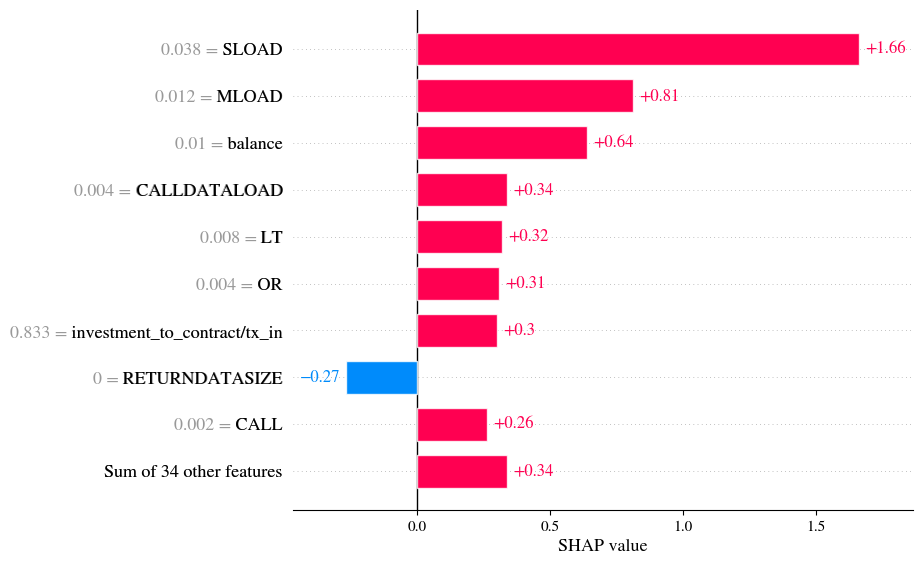

In [48]:
shap.plots.bar(shap_fn[0],show_data=True)


In [49]:
df_shap_fp = df_fp.sort_values('probability',ascending=False)[df_X_test_full.columns].copy()
shap_fp, shap_fp_tree = get_shaps(cls.named_steps['classifier'],df_shap_fp)

(11, 43)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


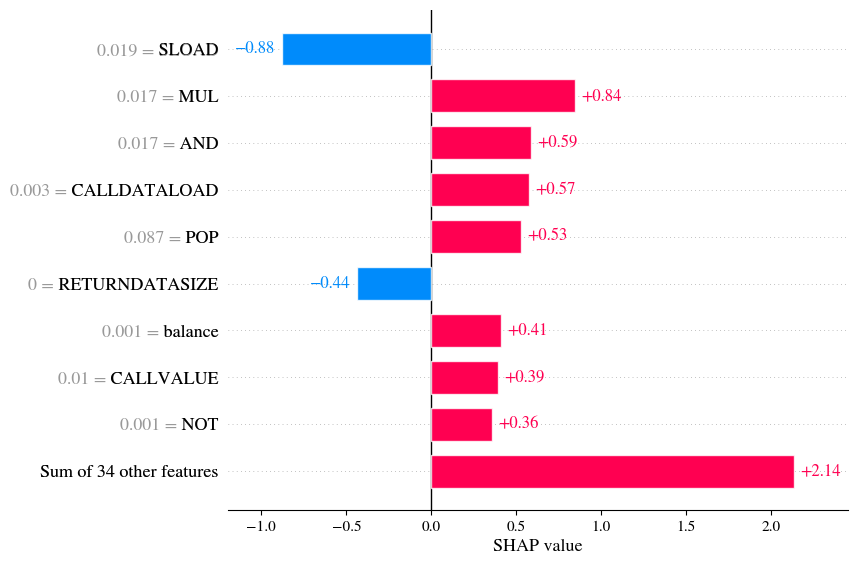

In [50]:
shap.plots.bar(shap_fp[0],show_data=True)

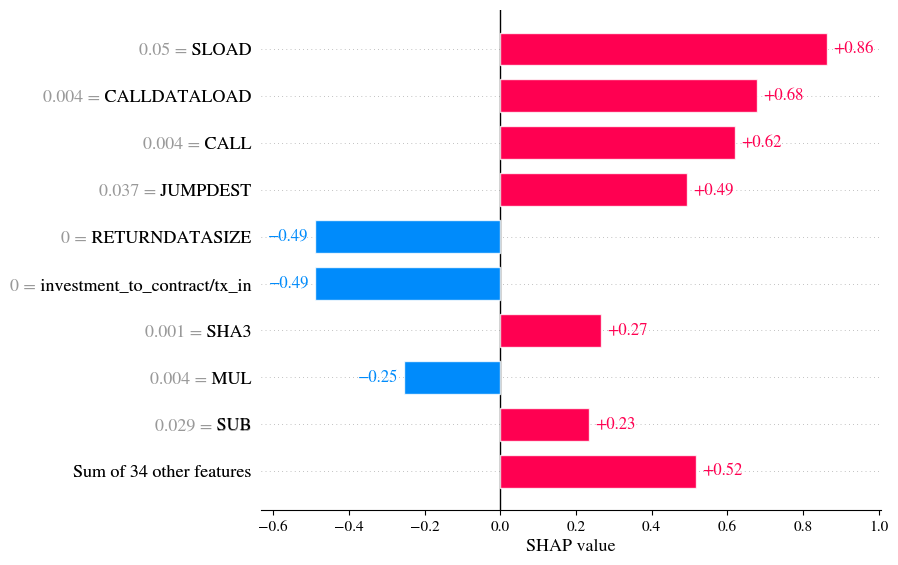

In [51]:
shap.plots.bar(shap_fp[1],show_data=True)

In [52]:
shap.initjs()
shap.force_plot(shap_fp[1])

In [53]:
shap.initjs()
shap.force_plot(shap_fp[2])

In [54]:
shap.initjs()
shap.force_plot(shap_fn[2])

In [55]:
shap.initjs()
shap.force_plot(shap_fn[3])

In [56]:
shap.force_plot(shap_values[0,:])

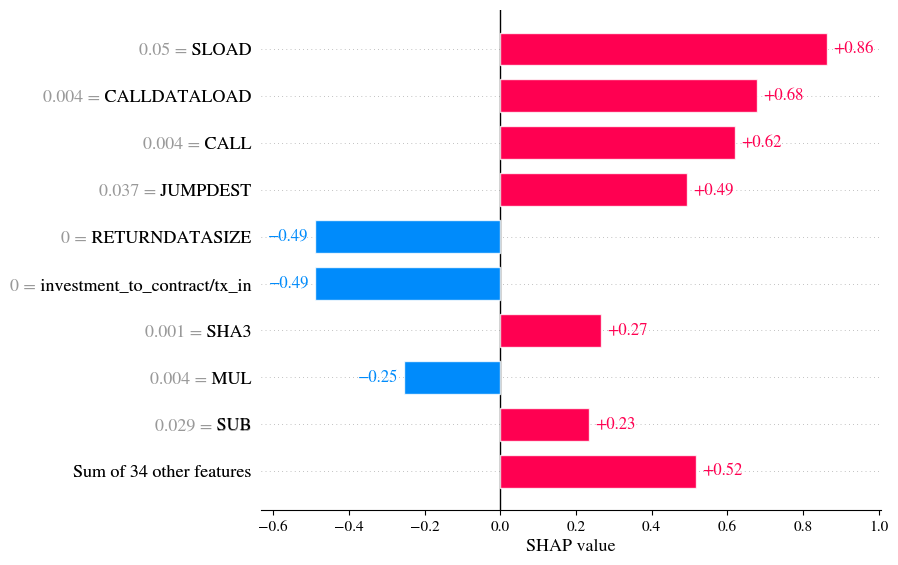

In [57]:
shap.plots.bar(shap_fp[1],show_data=True)

PDP with SHAP

In [58]:
top_ten = [
 'SLOAD',
 'GAS',
 'RETURNDATASIZE',
 'CALLDATALOAD',
 'AND',
 'MUL',
 'investment_to_contract/tx_in',
 'CALL',
 'SHA3',
 'paid_rate'
]

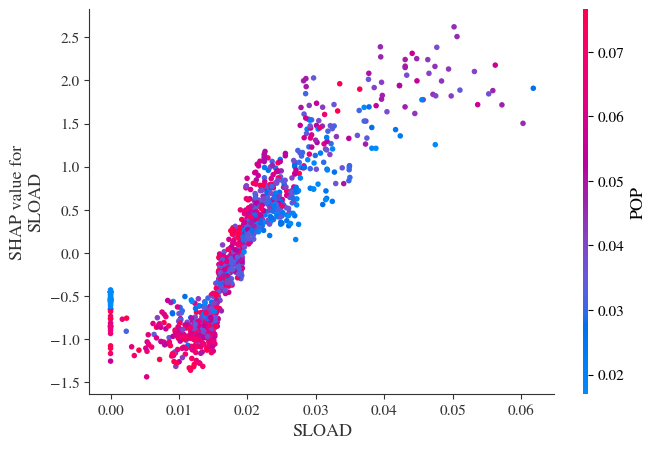

In [60]:
shap.dependence_plot("SLOAD", shap_values_tree[1], df_X_test_full)

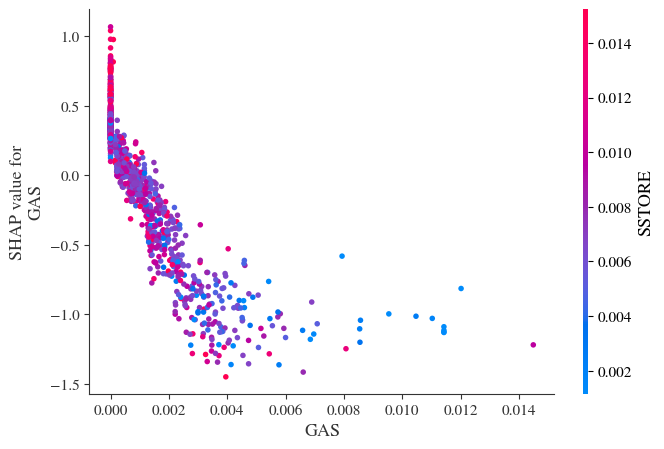

In [61]:
shap.dependence_plot("GAS", shap_values_tree[1], df_X_test_full)

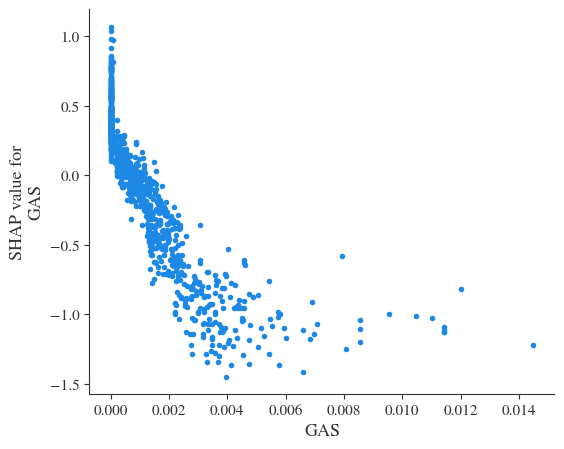

In [62]:
shap.dependence_plot("GAS", shap_values_tree[1], df_X_test_full,  interaction_index=None)

In [63]:
inds = shap.approximate_interactions("SLOAD",  shap_values_tree[1], df_X_test_full)

In [64]:
df_X_test_full.columns

Index(['balance', 'lifetime', 'tx_in', 'investment_to_contract/tx_in',
       'sdev_v2', 'paid_rate', 'PUSH', 'INVALID', 'DUP', 'JUMPDEST', 'STOP',
       'JUMPI', 'REVERT', 'CALLVALUE', 'ISZERO', 'CODECOPY', 'RETURN', 'LOG',
       'SHA3', 'SWAP', 'POP', 'ADD', 'MLOAD', 'AND', 'SUB', 'CALLDATALOAD',
       'EXP', 'MUL', 'SLOAD', 'JUMP', 'DIV', 'CALLER', 'SSTORE', 'NOT', 'CALL',
       'LT', 'GT', 'OR', 'TIMESTAMP', 'GAS', 'BALANCE3', 'CALLDATASIZE',
       'RETURNDATASIZE'],
      dtype='object')

In [65]:
inds

array([20,  8, 27, 21, 24, 11,  6,  9, 26, 23, 42, 18, 19,  3, 30, 16, 22,
       17, 15, 29, 37, 14, 13,  5, 32, 10, 25, 12, 38, 39, 35, 36, 34,  7,
       31,  1, 40,  2, 41, 33,  4,  0, 28])

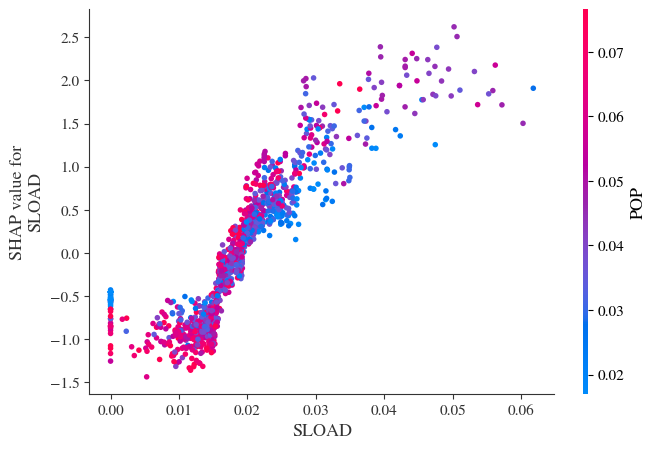

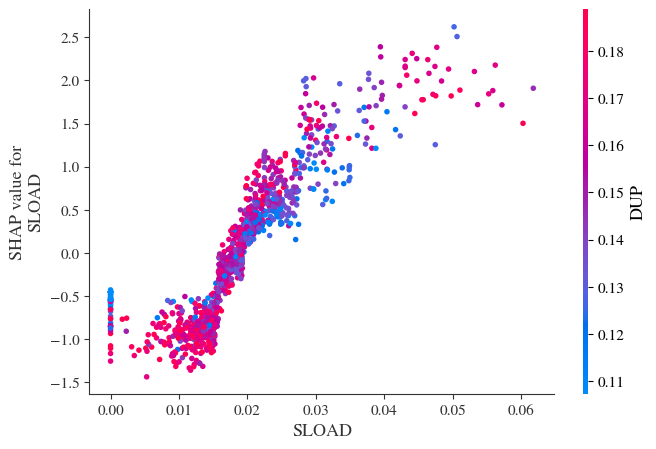

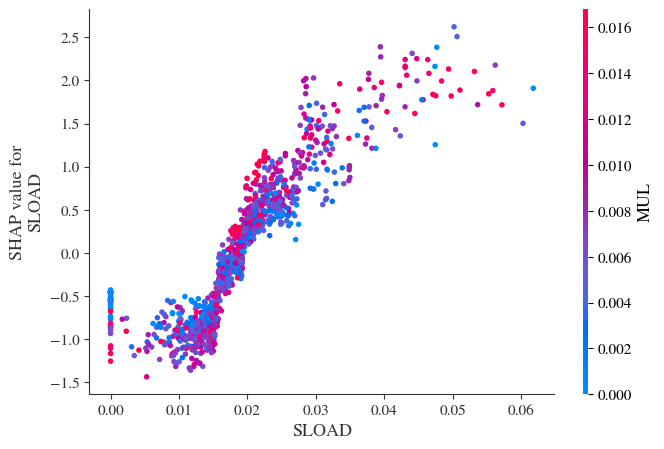

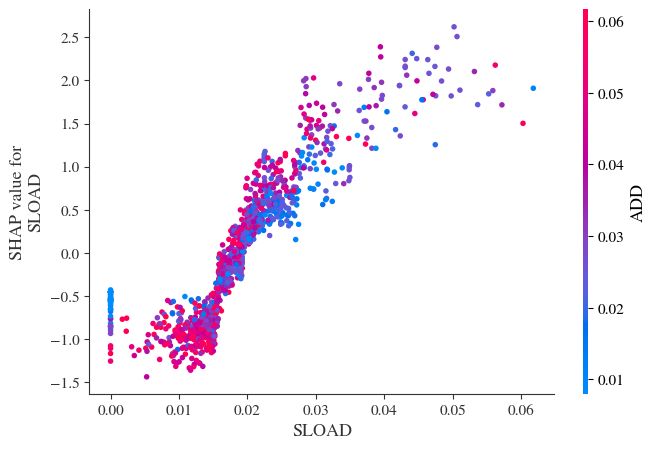

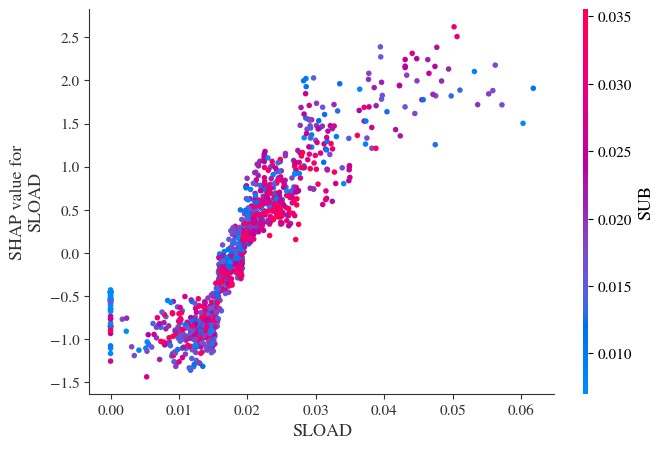

In [66]:
for i in range(5):
    shap.dependence_plot("SLOAD", shap_values_tree[1], df_X_test_full, interaction_index=inds[i])

In [68]:
top_ten = [
 'SLOAD',
 'GAS',
 'RETURNDATASIZE',
 'CALLDATALOAD',
 'AND',
 'MUL',
 'investment_to_contract/tx_in',
 'CALL',
 'SHA3',
 'paid_rate'
]

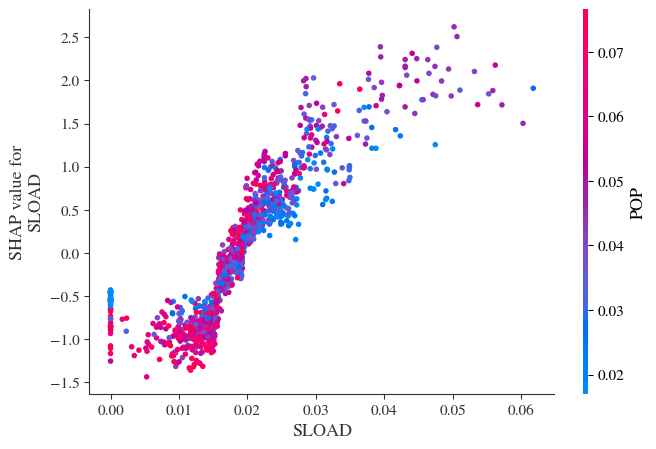

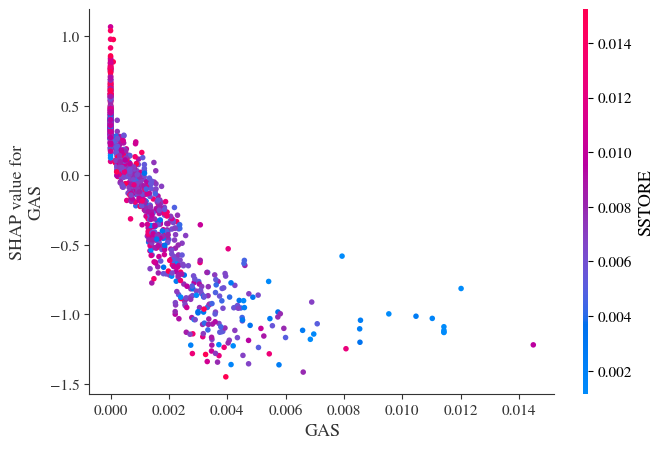

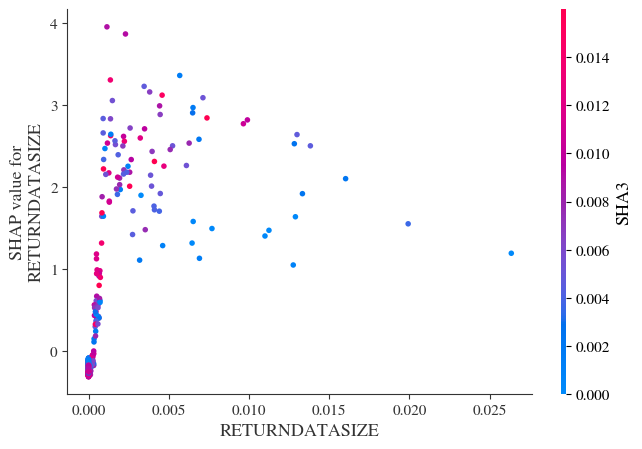

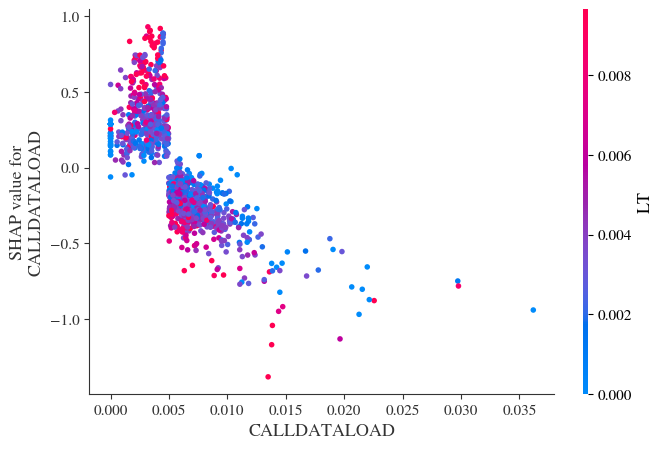

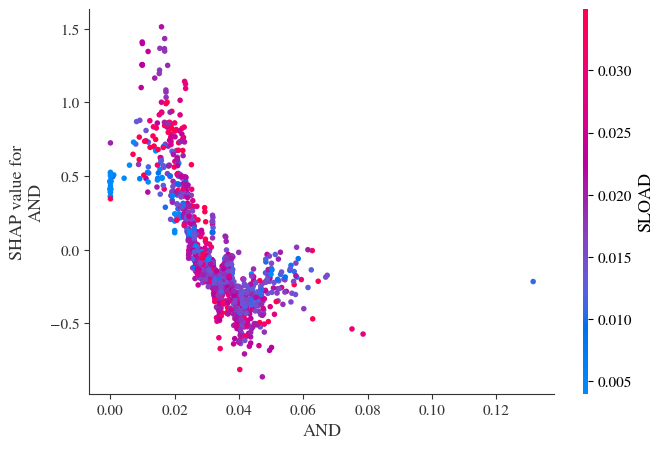

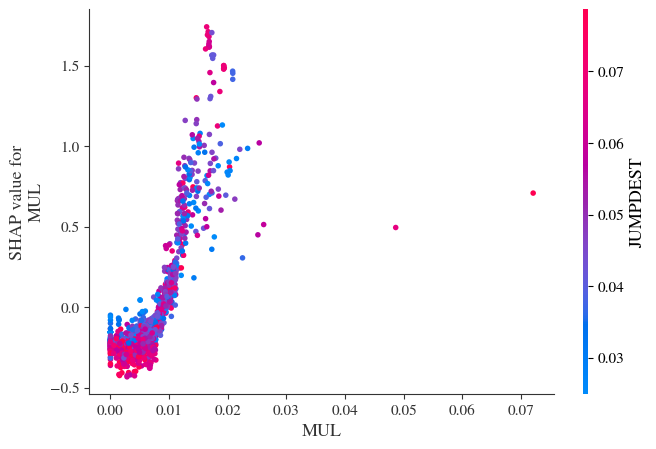

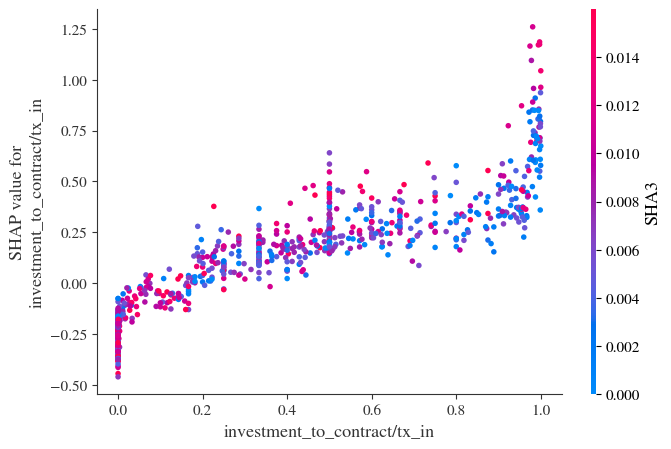

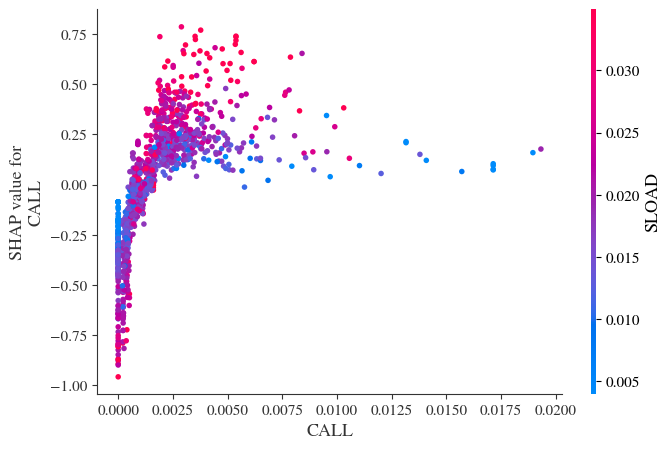

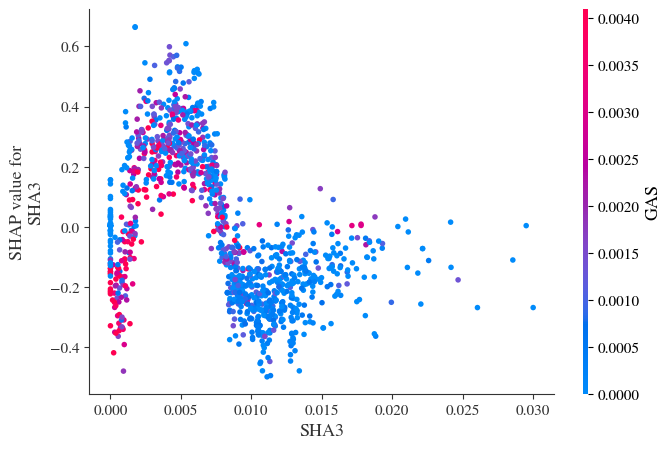

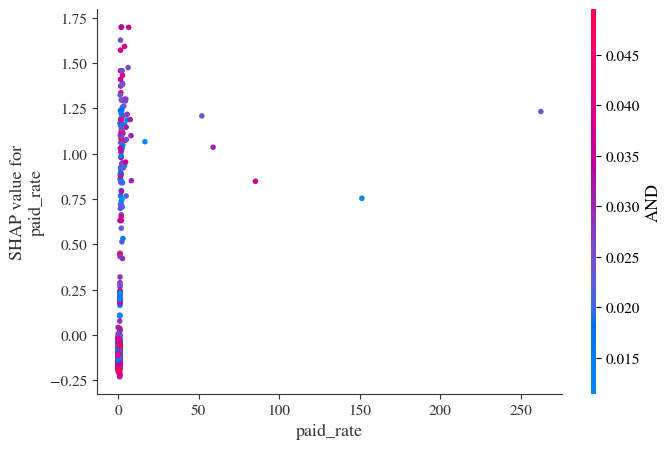

In [69]:
for i in top_ten:
  shap.dependence_plot(i, shap_values_tree[1], df_X_test_full)

In [ ]:
for x in top_ten:
  PartialDependenceDisplay.from_estimator(
    cls, df_X_test_full, [x])